/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-1-171f6d2749e4>:37: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),


Found 2052 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.2755 - loss: 1.6456 - val_accuracy: 0.4181 - val_loss: 1.3821
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.4293 - loss: 1.3904 - val_accuracy: 0.4795 - val_loss: 1.3065
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.4387 - loss: 1.3759 - val_accuracy: 0.4649 - val_loss: 1.2681
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4892 - loss: 1.2624 - val_accuracy: 0.5073 - val_loss: 1.1776
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.4835 - loss: 1.2473 - val_accuracy: 0.4708 - val_loss: 1.2072
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4614 - loss: 1.2127 - val_accuracy: 0.4415 - val_loss: 1.2967
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.4931 - loss: 1.1855 - val_accuracy: 0.4561 - val_loss: 1.1922
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4886 - loss: 1.1702 - val_accuracy: 0.4927 - val_loss: 1.

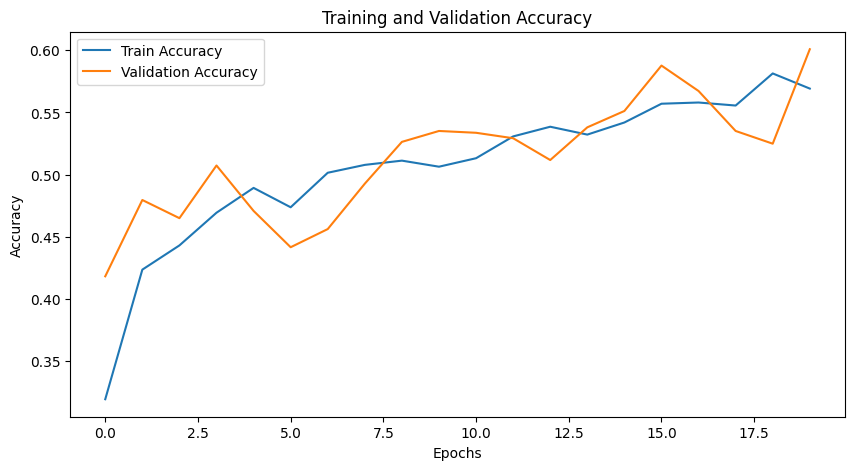

22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 740ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


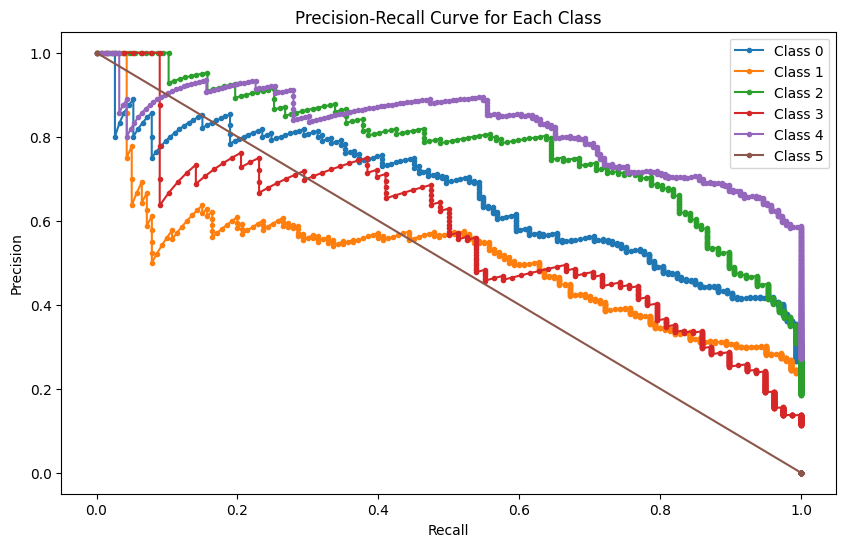

In [1]:
import os
import cv2
import numpy as np
import random
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Layer, Dropout, LayerNormalization, MultiHeadAttention, Add, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import AdamW
from sklearn.metrics import precision_recall_curve

# Set dataset paths
dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
output_path = "/kaggle/working/expanded_dataset"
final_dataset_path = "/kaggle/working/final_processed_dataset"

# Ensure only valid labels are considered
valid_labels = {"BLB", "Blast", "healthy", "hispa", "leaf folder", "leaf spot"}

# Create necessary directories
os.makedirs(output_path, exist_ok=True)
os.makedirs(final_dataset_path, exist_ok=True)

# Define augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.RandomResizedCrop(height=224, width=224, scale=(0.7, 1.0), p=0.5),
    A.GridDistortion(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

# Define image processing functions
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

def apply_filtering(img):
    return cv2.medianBlur(cv2.GaussianBlur(img, (5, 5), 0), 5)

def apply_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

def apply_morphology(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

# Expand dataset to 220 images per label
for label in os.listdir(dataset_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(dataset_path, label)
    save_path = os.path.join(output_path, label)
    os.makedirs(save_path, exist_ok=True)
    
    images = [os.path.join(label_path, img) for img in os.listdir(label_path)]
    
    while len(images) < 220:
        img_path = random.choice(images)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        augmented = augmentations(image=img)["image"]
        save_name = f"aug_{len(images)}.jpg"
        cv2.imwrite(os.path.join(save_path, save_name), augmented)
        images.append(os.path.join(save_path, save_name))

# Apply Processing Techniques
for label in os.listdir(output_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(output_path, label)
    save_label_path = os.path.join(final_dataset_path, label)
    os.makedirs(save_label_path, exist_ok=True)
    
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        
        # Save original and processed versions
        cv2.imwrite(os.path.join(save_label_path, f"orig_{img_file}"), img)
        cv2.imwrite(os.path.join(save_label_path, f"clahe_{img_file}"), apply_clahe(img))
        cv2.imwrite(os.path.join(save_label_path, f"filtered_{img_file}"), apply_filtering(img))
        cv2.imwrite(os.path.join(save_label_path, f"thresh_{img_file}"), apply_thresholding(img))
        cv2.imwrite(os.path.join(save_label_path, f"morph_{img_file}"), apply_morphology(img))

# Custom Patch Extraction Layer
class PatchExtractor(Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Transformer Block
class TransformerBlock(Layer):
    def __init__(self, projection_dim, num_heads, mlp_units, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout)
        self.mlp = tf.keras.Sequential([
            Dense(mlp_units, activation="gelu"),
            Dropout(dropout),
            Dense(projection_dim),
            Dropout(dropout),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.add1 = Add()
        self.add2 = Add()

    def call(self, inputs):
        x = self.layernorm1(inputs)
        attention_output = self.mha(x, x)
        x = self.add1([attention_output, inputs])
        x2 = self.layernorm2(x)
        x3 = self.mlp(x2)
        return self.add2([x3, x])

# Load dataset and split into Train/Validation/Test
all_images, all_labels = [], []
label_map = {label: idx for idx, label in enumerate(valid_labels)}

for label in valid_labels:
    label_path = os.path.join(final_dataset_path, label)
    if not os.path.exists(label_path):
        continue
    for img_file in os.listdir(label_path):
        if img_file.endswith('.jpg'):
            all_images.append(os.path.join(label_path, img_file))
            all_labels.append(label_map[label])

train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings for ImageDataGenerator
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

# Create data generators
datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

def create_vit_model(
    input_shape,
    patch_size,
    projection_dim,
    num_heads,
    transformer_layers,
    mlp_head_units,
    num_classes,
    dropout=0.1
):
    inputs = Input(shape=input_shape)
    
    # Extract patches
    patches = PatchExtractor(patch_size)(inputs)
    
    # Create patch embedding
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patch_embed = Dense(projection_dim)(patches)
    
    # Add position embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    encoded = patch_embed + position_embedding
    
    # Add dropout to embeddings
    encoded = Dropout(dropout)(encoded)
    
    # Create transformer blocks
    for _ in range(transformer_layers):
        encoded = TransformerBlock(
            projection_dim,
            num_heads,
            mlp_units=projection_dim * 4,
            dropout=dropout
        )(encoded)
    
    # Layer norm and global average pooling
    representation = LayerNormalization(epsilon=1e-6)(encoded)
    representation = GlobalAveragePooling1D()(representation)
    
    # MLP head
    features = Dropout(dropout)(representation)
    for units in mlp_head_units:
        features = Dense(units, activation="gelu")(features)
        features = Dropout(dropout)(features)
    
    # Classification head
    outputs = Dense(num_classes, activation="softmax")(features)
    
    return Model(inputs=inputs, outputs=outputs)

# Create and compile ViT model
input_shape = (224, 224, 3)
patch_size = 16
projection_dim = 64
num_heads = 4
transformer_layers = 8
mlp_head_units = [256, 128]

model = create_vit_model(
    input_shape=input_shape,
    patch_size=patch_size,
    projection_dim=projection_dim,
    num_heads=num_heads,
    transformer_layers=transformer_layers,
    mlp_head_units=mlp_head_units,
    num_classes=len(valid_labels)
)

# Compile model
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weight_dict
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Compute and plot PR curves
num_classes = len(valid_labels)
y_true = tf.keras.utils.to_categorical(test_gen.classes, num_classes)
y_probs = model.predict(test_gen)

plt.figure(figsize=(10, 6))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()